In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chi2

# Load Alfentanil dose-effectiveness data
dose_data = pd.read_csv('newtonmethod.csv')  
x_dose = dose_data['xaxis1'] 
y_effectiveness = dose_data['yaxis1']  

# Load Quinidine time-concentration data
time_data = pd.read_csv('newtonmethod.csv')  
x_time = time_data['xaxis2']  
y_concentration = time_data['yaxis2'] 

# Define functions for fitting
def hyperbola(x, a, b):
    return a * x / (x + b)

def logarithmic(x, a, b):
    return a * np.log(x) + b

def exponential(x, a, b):
    return a * np.exp(-b * x)

# List of functions to try
functions = {
    "Hyperbola": hyperbola,
    "Logarithmic": logarithmic,
    "Exponential": exponential
}

# Function to fit data and calculate RSS and p-value
def fit_data(x_data, y_data, label):
    results = []
    for name, func in functions.items():
        try:
            # Fit data
            params, _ = curve_fit(func, x_data, y_data)
            residuals = y_data - func(x_data, *params)
            rss = np.sum(residuals ** 2)

            # Calculate p-value
            n = len(y_data)
            p = len(params)
            p_value = 1 - chi2.cdf(rss, n - p)

            # Store results with coefficients
            results.append((name, params, rss, p_value))
        except Exception as e:
            print(f"Could not fit {name} function for {label}: {e}")

    # Display results for the dataset
    print(f"Results for {label} data:")
    for result in results:
        name, params, rss, p_value = result
        coef_str = ", ".join([f"{param:.5f}" for param in params])
        print(f"Function: {name}, Coefficients: [{coef_str}], RSS: {rss:.5f}, p-value: {p_value:.5f}")
    print("\n")

    return results
    
# Fit and display results for both datasets
alfentanil_results = fit_data(x_dose, y_effectiveness, "Alfentanil dose-effectiveness")
quinidine_results = fit_data(x_time, y_concentration, "Quinidine time-concentration")

Results for Alfentanil dose-effectiveness data:
Function: Hyperbola, Coefficients: [0.42116, 0.17570], RSS: 0.02344, p-value: 1.00000
Function: Logarithmic, Coefficients: [0.07988, 0.35669], RSS: 0.02475, p-value: 1.00000
Function: Exponential, Coefficients: [0.23892, -0.35684], RSS: 0.03958, p-value: 1.00000


Results for Quinidine time-concentration data:
Function: Hyperbola, Coefficients: [0.25585, -0.04169], RSS: 0.04439, p-value: 1.00000
Function: Logarithmic, Coefficients: [-0.07727, 0.25180], RSS: 0.02645, p-value: 1.00000
Function: Exponential, Coefficients: [0.40969, 0.47637], RSS: 0.02753, p-value: 1.00000




In [ ]:
def display_best_model(results, label):
    # Find the model with the lowest RSS
    best_model = min(results, key=lambda x: x[2])  # Sort by RSS
    name, params, rss, p_value = best_model
    
    # Display parameters with labels a and b
    print(f"{label} Study ({name} Model)")
    print(f"Parameters: a = {params[0]:.5f}, b = {params[1]:.5f}")
    print(f"RSS: {rss:.5f}, p-value: {p_value:.5f}\n")

# Display the best model for each dataset
display_best_model(alfentanil_results, "Dose-Effectiveness")
display_best_model(quinidine_results, "Time-Concentration")

Dose-Effectiveness Study (Hyperbola Model)
Parameters: a = 0.42116, b = 0.17570
RSS: 0.02344, p-value: 1.00000

Time-Concentration Study (Logarithmic Model)
Parameters: a = -0.07727, b = 0.25180
RSS: 0.02645, p-value: 1.00000



Initial concentration (C0): -0.07726887351200551
Elimination constant or equivalent parameter: 0.2517981954778815


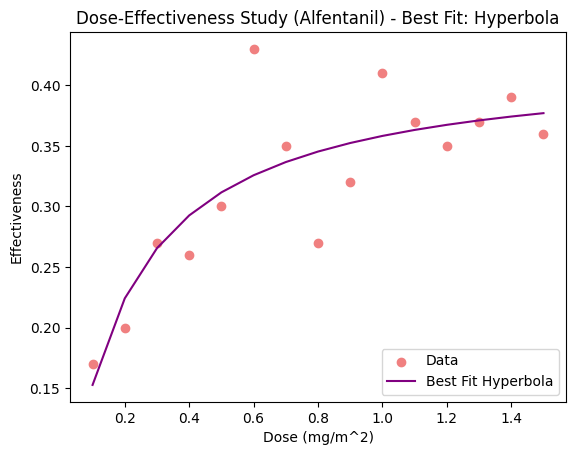

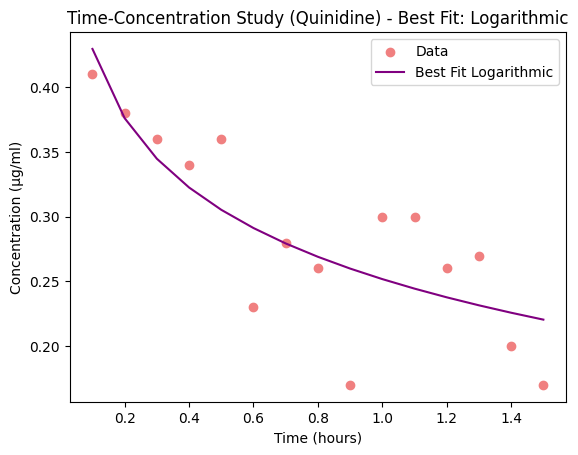

In [25]:
import matplotlib.pyplot as plt

# Extract the best fit parameters for each study
best_dose_model = min(alfentanil_results, key=lambda x: x[2])  # Best model for Dose-Effectiveness
best_time_model = min(quinidine_results, key=lambda x: x[2])   # Best model for Time-Concentration

# Assign parameter names based on the best model for dose-effectiveness
dose_model_name = best_dose_model[0]
dose_params = best_dose_model[1]

# Assign parameter names based on the best model for time-concentration
time_model_name = best_time_model[0]
time_params = best_time_model[1]

# Display parameters for Time-Concentration Study based on the best model
print(f"Initial concentration (C0): {time_params[0]}")
print(f"Elimination constant or equivalent parameter: {time_params[1]}")

# Plot for Dose-Effectiveness Study
plt.figure()
plt.scatter(x_dose, y_effectiveness, label="Data", color='lightcoral')
plt.plot(x_dose, functions[dose_model_name](x_dose, *dose_params), label=f"Best Fit {dose_model_name}", color='purple')
plt.xlabel("Dose (mg/m^2)")
plt.ylabel("Effectiveness")
plt.title(f"Dose-Effectiveness Study (Alfentanil) - Best Fit: {dose_model_name}")
plt.legend()
plt.show()

# Plot for Time-Concentration Study
plt.figure()
plt.scatter(x_time, y_concentration, label="Data", color='lightcoral')
plt.plot(x_time, functions[time_model_name](x_time, *time_params), label=f"Best Fit {time_model_name}", color='purple')
plt.xlabel("Time (hours)")
plt.ylabel("Concentration (μg/ml)")
plt.title(f"Time-Concentration Study (Quinidine) - Best Fit: {time_model_name}")
plt.legend()
plt.show()


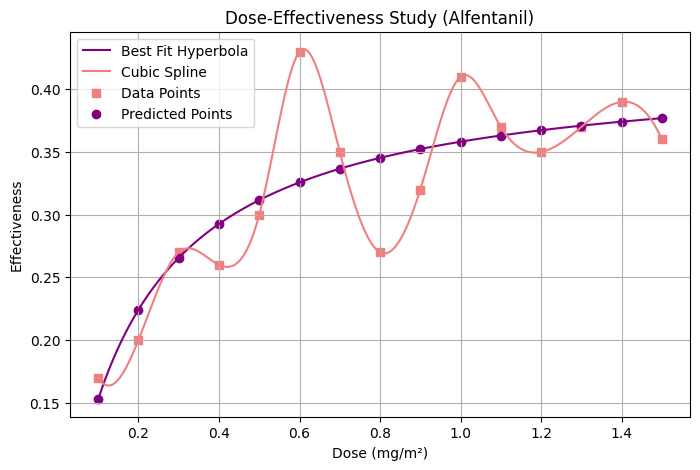

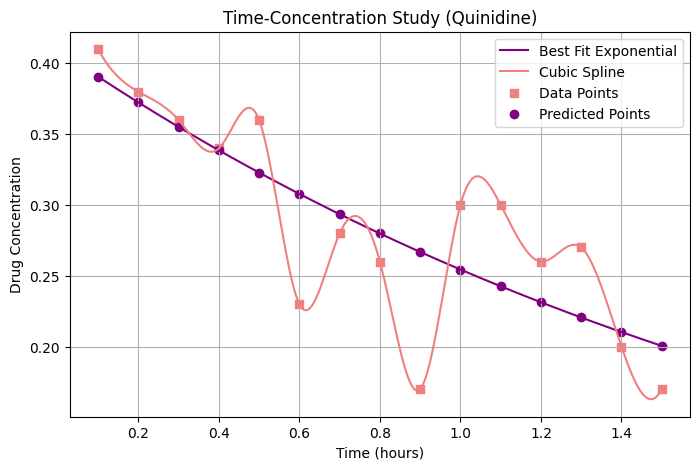

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline

# Assuming you have the following functions defined as per the previous instructions:
def hyperbola(x, a, b):
    return a * x / (x + b)

def exponential(x, a, b):
    return a * np.exp(-b * x)

# Fit the models
params_hyperbola, _ = curve_fit(hyperbola, x_dose, y_effectiveness)
params_exponential, _ = curve_fit(exponential, x_time, y_concentration)

# Generate smooth lines with cubic splines
x_dose_smooth = np.linspace(x_dose.min(), x_dose.max(), 300)
x_time_smooth = np.linspace(x_time.min(), x_time.max(), 300)

# Generate predictions based on the fitted models
predicted_effectiveness = hyperbola(x_dose, *params_hyperbola)
predicted_concentration = exponential(x_time, *params_exponential)

# Cubic spline interpolation for smooth curves
spline_effectiveness = make_interp_spline(x_dose, y_effectiveness)(x_dose_smooth)
spline_concentration = make_interp_spline(x_time, y_concentration)(x_time_smooth)

# Plot for Dose-Effectiveness Study
plt.figure(figsize=(8, 5))
plt.plot(x_dose_smooth, hyperbola(x_dose_smooth, *params_hyperbola), label="Best Fit Hyperbola", color='purple')
plt.plot(x_dose_smooth, spline_effectiveness, label="Cubic Spline", color='lightcoral')
plt.scatter(x_dose, y_effectiveness, color='lightcoral', marker='s', label="Data Points")  # Original data points
plt.scatter(x_dose, predicted_effectiveness, color='purple', marker='o', label="Predicted Points")  # Predicted points
plt.xlabel("Dose (mg/m²)")
plt.ylabel("Effectiveness")
plt.title("Dose-Effectiveness Study (Alfentanil)")
plt.legend()
plt.grid(True)
plt.show()

# Plot for Time-Concentration Study
plt.figure(figsize=(8, 5))
plt.plot(x_time_smooth, exponential(x_time_smooth, *params_exponential), label="Best Fit Exponential", color='purple')
plt.plot(x_time_smooth, spline_concentration, label="Cubic Spline", color='lightcoral')
plt.scatter(x_time, y_concentration, color='lightcoral', marker='s', label="Data Points")  # Original data points
plt.scatter(x_time, predicted_concentration, color='purple', marker='o', label="Predicted Points")  # Predicted points
plt.xlabel("Time (hours)")
plt.ylabel("Drug Concentration")
plt.title("Time-Concentration Study (Quinidine)")
plt.legend()
plt.grid(True)
plt.show()
